In [2]:
import os
import requests
import pdal
import json

# File containing the URLs
filename = 'liste_dalle.txt'

# Log file to track completed downloads
log_file = 'downloaded_log.txt'

# Directory for temporary files
temp_dir = 'temp_lidar_data'
os.makedirs(temp_dir, exist_ok=True)

# Directory for storing processed output TIFFs
output_dir = 'output_tiffs'
os.makedirs(output_dir, exist_ok=True)

def download_file(url, local_filename):
    # Download the file
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                f.write(chunk)

def process_lidar_file(local_filename):
    # Process roofs
    roof_output = os.path.join(output_dir, os.path.basename(local_filename).replace('.laz', '_roofs.tif'))
    roof_pipeline = {
        "pipeline": [
            {
                "type": "readers.copc",
                "filename": local_filename
            },
            {
                "type": "filters.range",
                "limits": "Classification[6:6]",  # Roofs Classification
            },
            {
                "type": "writers.gdal",
                "filename": roof_output,
                "resolution": 5.0,
                "output_type": "mean"
            }
        ]
    }
    pipeline_json = json.dumps(roof_pipeline)
    p = pdal.Pipeline(pipeline_json)
    p.execute()

    # Process ground
    ground_output = os.path.join(output_dir, os.path.basename(local_filename).replace('.laz', '_ground.tif'))
    ground_pipeline = {
        "pipeline": [
            {
                "type": "readers.copc",
                "filename": local_filename
            },
            {
                "type": "filters.range",
                "limits": "Classification[2:2]",  # Ground Classification
            },
            {
                "type": "writers.gdal",
                "filename": ground_output,
                "resolution": 30.0,
                "output_type": "mean"
            }
        ]
    }
    pipeline_json = json.dumps(ground_pipeline)
    p = pdal.Pipeline(pipeline_json)
    p.execute()

    return roof_output, ground_output

def log_downloaded(url):
    # Write the completed URL to the log file
    with open(log_file, 'a') as log:
        log.write(url + '\n')

def already_downloaded(url):
    # Check if the URL has already been processed
    if os.path.exists(log_file):
        with open(log_file, 'r') as log:
            completed_urls = log.read().splitlines()
        return url in completed_urls
    return False

def main():
    with open(filename, 'r') as f:
        urls = f.readlines()

    for url in urls:
        url = url.strip()
        if not url:  # Skip empty URLs
            continue

        if already_downloaded(url):
            print(f"Skipping {url}, already downloaded and processed.")
            continue
        
        filename_from_url = os.path.basename(url)
        if not filename_from_url:  # Skip if the URL doesn't provide a valid filename
            print(f"Error: Could not extract a valid filename from {url}")
            continue

        local_file = os.path.join(temp_dir, filename_from_url)  # Create full local file path

        try:
            # Download the file
            print(f"Downloading {url}...")
            download_file(url, local_file)

            # Process roof and ground, and remove the laz file after processing
            roof_file, ground_file = process_lidar_file(local_file)

            print(f"Processed {local_file}. Removing it...")
            os.remove(local_file)

            # Log the URL as successfully processed
            log_downloaded(url)

        except Exception as e:
            print(f"Error processing {url}: {e}")
            # Do not log the URL if an error occurred

    print(f"Processing completed. Processed files are saved in {output_dir}")

if __name__ == "__main__":
    main()


Processed temp_lidar_data/LHD_FXX_0661_6866_PTS_O_LAMB93_IGN69.copc.laz. Removing it...
Processed temp_lidar_data/LHD_FXX_0661_6867_PTS_O_LAMB93_IGN69.copc.laz. Removing it...
Processed temp_lidar_data/LHD_FXX_0661_6868_PTS_O_LAMB93_IGN69.copc.laz. Removing it...
Processed temp_lidar_data/LHD_FXX_0661_6869_PTS_O_LAMB93_IGN69.copc.laz. Removing it...
Processed temp_lidar_data/LHD_FXX_0661_6870_PTS_O_LAMB93_IGN69.copc.laz. Removing it...
Processed temp_lidar_data/LHD_FXX_0661_6862_PTS_O_LAMB93_IGN69.copc.laz. Removing it...
Processed temp_lidar_data/LHD_FXX_0661_6863_PTS_O_LAMB93_IGN69.copc.laz. Removing it...
Processed temp_lidar_data/LHD_FXX_0661_6864_PTS_O_LAMB93_IGN69.copc.laz. Removing it...
Processed temp_lidar_data/LHD_FXX_0661_6865_PTS_O_LAMB93_IGN69.copc.laz. Removing it...
Processed temp_lidar_data/LHD_FXX_0661_6858_PTS_O_LAMB93_IGN69.copc.laz. Removing it...
Processed temp_lidar_data/LHD_FXX_0661_6859_PTS_O_LAMB93_IGN69.copc.laz. Removing it...
Processed temp_lidar_data/LHD_FX

## Next steps towards the raster

In [5]:
#!pip install rasterstats

In [4]:
#!head $CONDA_PREFIX/share/proj/proj.db

In [182]:
import os
import numpy as np
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
from shapely.geometry import box
from rasterstats import zonal_stats
from scipy.ndimage import distance_transform_edt
from tqdm import tqdm

# --- Parameters ---
roof_dir = "output_tiffs"
ground_dir = "output_tiffs"
building_fp = "/Users/gabeiras3j/01_year_2/01_Data/21_Microsoft_buildings/example_building_footprints_Paris.geojson"
global_raster_path = "/Users/gabeiras3j/Desktop/Jacobo/00_PhD/01_year_2/01_Data/02_WUDAPT/00_Global/lambda_b_v3_2d_correct_account.tiff"
output_raster_path = "lambda_b_updated_Paris_lidar.tif"
invalid_height_value = -9999

# --- UTIL: Fill missing data using nearest valid neighbor ---
def fill_nearest(data, nodata=np.nan):
    mask = np.isnan(data) if np.isnan(nodata) else (data == nodata)
    inds = distance_transform_edt(mask, return_distances=False, return_indices=True)
    return data[tuple(inds)]

# --- STEP 1: Merge tiles ---
def merge_tiles(tile_dir, keyword):
    files = [os.path.join(tile_dir, f) for f in os.listdir(tile_dir) if keyword in f and f.endswith(".tif")]
    srcs = [rasterio.open(f) for f in files]
    mosaic, out_trans = merge(srcs)
    meta = srcs[0].meta.copy()
    meta.update({"height": mosaic.shape[1], "width": mosaic.shape[2], "transform": out_trans, "dtype": "float32"})
    for src in srcs:
        src.close()
    return mosaic[0].astype(np.float32), meta

print("Merging and filling roof and ground rasters...")
roof_raw, meta = merge_tiles(roof_dir, "_roofs")
ground_raw, meta2 = merge_tiles(ground_dir, "_ground")

roof_filled = fill_nearest(np.where(roof_raw == invalid_height_value, np.nan, roof_raw))
ground_filled = fill_nearest(np.where(ground_raw == invalid_height_value, np.nan, ground_raw))

Merging and filling roof and ground rasters...


In [186]:
# --- STEP 2: Resample ground to roof grid ---
print("Resampling ground to match roof resolution...")
resampled_ground = np.full_like(roof_filled, invalid_height_value, dtype=np.float32)

reproject(
    source=ground_filled,
    destination=resampled_ground,
    src_transform=meta2["transform"],
    src_crs=meta2["crs"],
    dst_transform=meta["transform"],
    dst_crs=meta["crs"],
    resampling=Resampling.nearest,
    src_nodata=invalid_height_value,
    dst_nodata=invalid_height_value
)


Resampling ground to match roof resolution...


(array([[ 34.04624 ,  34.04624 ,  34.04624 , ...,  52.84358 ,  52.84358 ,
          52.84358 ],
        [ 34.04624 ,  34.04624 ,  34.04624 , ...,  52.84358 ,  52.84358 ,
          52.84358 ],
        [ 34.04624 ,  34.04624 ,  34.04624 , ...,  52.84358 ,  52.84358 ,
          52.84358 ],
        ...,
        [161.25832 , 161.25832 , 161.25832 , ...,  33.177315,  33.177315,
          33.177315],
        [161.25832 , 161.25832 , 161.25832 , ...,  33.177315,  33.177315,
          33.177315],
        [161.25832 , 161.25832 , 161.25832 , ...,  33.177315,  33.177315,
          33.177315]], shape=(3201, 4201), dtype=float32),
 Affine(5.0, 0.0, 641000.0,
        0.0, -5.0, 6870005.0))

In [189]:
# --- STEP 3: Height raster ---
print("Computing height raster...")
height_raster = roof_filled - resampled_ground
height_raster[roof_filled == 0] = np.nan

Computing height raster...


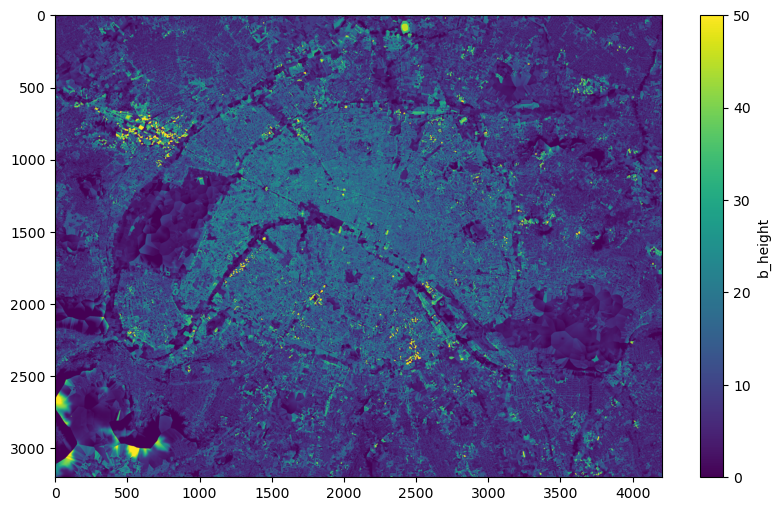

In [194]:
plt.figure(figsize=(10, 6))
plt.imshow(height_raster, cmap="viridis",vmin=0,vmax=50)
# plt.title("λ_B for AOI")
plt.colorbar(label="b_height")
plt.show()

In [217]:
# --- STEP 4: Assign building heights ---
print("Assigning heights to building footprints...")
buildings = gpd.read_file(building_fp)
buildings = buildings.to_crs(meta["crs"])
buildings["building_id"] = np.arange(len(buildings))

# Fix invalid geometries
print("Fixing invalid building geometries...")
buildings["geometry"] = buildings["geometry"].buffer(0)

# Primary assignment using zonal stats
zs = zonal_stats(buildings, height_raster, affine=meta["transform"], stats="mean", nodata=np.nan)
buildings["height"] = [z["mean"] if z["mean"] is not None else np.nan for z in zs]

Assigning heights to building footprints...
Fixing invalid building geometries...


In [227]:
# run this is need heights for testing
buildings['heightMS'] = [float(buildings['properties'][i][12:15]) for i in buildings.index]

In [221]:
buildings[~buildings["height"].isna()].shape

(127762, 6)

In [231]:
# Fallback using centroid sampling
print("Filling missing heights using centroid...")
missing = (buildings["height"]<0)
centroids = buildings.loc[missing].geometry.centroid
inv_transform = ~meta["transform"]
rows, cols = zip(*[inv_transform * (pt.x, pt.y) for pt in centroids]) if len(centroids) > 0 else ([], [])
rows = np.floor(rows).astype(int)
cols = np.floor(cols).astype(int)

sampled_heights = []
for r, c in zip(rows, cols):
    if 0 <= r < height_raster.shape[0] and 0 <= c < height_raster.shape[1]:
        val = height_raster[r, c]
        sampled_heights.append(val if not np.isnan(val) else invalid_height_value)
    else:
        sampled_heights.append(invalid_height_value)

buildings.loc[missing, "height"] = sampled_heights

# Fallback using nearest raster cell for remaining invalids
print("Final fallback using nearest non-nan in raster...")
still_missing = buildings["height"] == invalid_height_value
centroids = buildings.loc[still_missing].geometry.centroid
rows, cols = zip(*[inv_transform * (pt.x, pt.y) for pt in centroids]) if len(centroids) > 0 else ([], [])
rows = np.floor(rows).astype(int)
cols = np.floor(cols).astype(int)

filled_raster = fill_nearest(height_raster)
final_sampled_heights = []
for r, c in zip(rows, cols):
    if 0 <= r < filled_raster.shape[0] and 0 <= c < filled_raster.shape[1]:
        val = filled_raster[r, c]
        final_sampled_heights.append(val)
    else:
        final_sampled_heights.append(invalid_height_value)

buildings.loc[still_missing, "height"] = final_sampled_heights
valid_buildings = buildings[buildings["height"] != invalid_height_value].copy()


Filling missing heights using centroid...
Final fallback using nearest non-nan in raster...


In [233]:
# Fina fallback using MS heights
print("Filling missing heights using centroid...")
missing = (buildings["height"]<0)

heights_MS = buildings['heightMS'][missing]
buildings.loc[still_missing, "height"] = heights_MS

valid_buildings = buildings[buildings["height"]>0]

Filling missing heights using centroid...


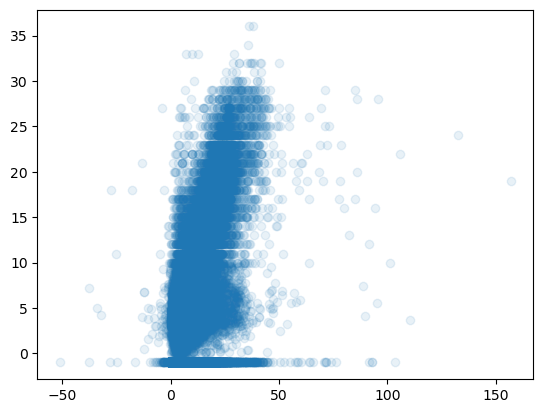

In [236]:
plt.scatter(buildings['height'],buildings['heightMS'],alpha=0.1)#.query('height>0')
# plt.xlim(-10,50)
# plt.ylim(-10,50)

Cropping global raster and calculating λ_B...
Generating raster-aligned grid...
Assigning buildings to grid cells with intersects predicate...
Saving λ_B raster to lambda_b_updated_Paris_lidar.tif...


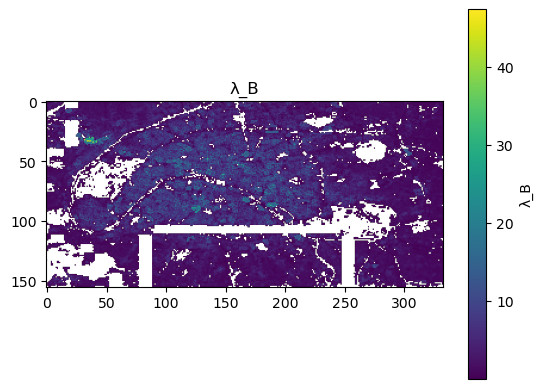

✅ λ_B raster generation complete.


In [247]:
# --- STEP 5: λ_B calculation ---
print("Cropping global raster and calculating λ_B...")
with rasterio.open(global_raster_path) as src:
    global_crs = src.crs
    global_transform = src.transform
    global_meta = src.meta.copy()

    valid_buildings = valid_buildings.to_crs(global_crs)
    bbox = valid_buildings.total_bounds
    window_geom = box(*bbox)
    geo = gpd.GeoDataFrame({"geometry": [window_geom]}, crs=global_crs)
    out_image, out_transform = mask(src, geo.geometry, crop=True)
    cropped_meta = src.meta.copy()
    cropped_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "compress": "lzw",
        "tiled": True,
        "dtype": "float32"
    })
    global_array = out_image[0]

updated = np.full(global_array.shape, invalid_height_value, dtype=np.float32)

# Build grid cells
print("Generating raster-aligned grid...")
res_x = abs(out_transform[0])
res_y = abs(out_transform[4])
rows, cols = updated.shape
grid_polys = []
for row in range(rows):
    for col in range(cols):
        x, y = out_transform * (col + 0.5, row + 0.5)
        poly = box(x - res_x / 2, y - res_y / 2, x + res_x / 2, y + res_y / 2)
        grid_polys.append((row, col, poly))

grid_gdf = gpd.GeoDataFrame(
    [(r, c) for r, c, _ in grid_polys],
    geometry=[g for _, _, g in grid_polys],
    columns=["row", "col"],
    crs=global_crs
)

# Reproject both for accurate geometry ops
def get_utm_crs(geo_df):
    centroid = geo_df.unary_union.centroid
    lon, lat = centroid.x, centroid.y
    zone_number = int((lon + 180) / 6) + 1
    return f"EPSG:{32600 + zone_number}" if lat >= 0 else f"EPSG:{32700 + zone_number}"

utm_crs = get_utm_crs(valid_buildings)
valid_buildings_proj = valid_buildings.to_crs(utm_crs)
grid_proj = grid_gdf.to_crs(utm_crs)
cell_area = grid_proj.geometry.iloc[0].area

# Spatial join with intersects only — no intersection geometry needed
print("Assigning buildings to grid cells with intersects predicate...")
joined = gpd.sjoin(valid_buildings_proj, grid_proj, how="inner", predicate="intersects")

joined["roof_area"] = joined.geometry.area
joined["perimeter"] = joined.geometry.length
joined["wall_area"] = joined["perimeter"] * joined["height"]
joined["lambda_b"] = (joined["roof_area"] + joined["wall_area"]) / cell_area

lambda_b_by_cell = (
    joined.groupby(["row", "col"])
    .agg({"lambda_b": "sum"})
    .reset_index()
)

for _, row in lambda_b_by_cell.iterrows():
    r, c = int(row["row"]), int(row["col"])
    updated[r, c] = row["lambda_b"]

# Save
print(f"Saving λ_B raster to {output_raster_path}...")
with rasterio.open(output_raster_path, "w", **cropped_meta) as dest:
    dest.write(updated, 1)

plt.imshow(np.ma.masked_equal(updated, invalid_height_value), cmap="viridis")
plt.title("λ_B")
plt.colorbar(label="λ_B")
plt.show()

print("✅ λ_B raster generation complete.")


In [237]:
# --- STEP 5: Crop global raster to AOI ---
print("Cropping global raster to AOI...")
with rasterio.open(global_raster_path) as src:
    global_crs = src.crs
    global_transform = src.transform
    global_meta = src.meta.copy()

    valid_buildings = valid_buildings.to_crs(global_crs)
    bbox = valid_buildings.total_bounds
    window_geom = box(*bbox)
    geo = gpd.GeoDataFrame({'geometry': [window_geom]}, crs=global_crs)
    out_image, out_transform = mask(src, geo.geometry, crop=True)
    cropped_meta = src.meta.copy()
    cropped_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "compress": "lzw",
        "tiled": True,
        "dtype": "float32"
    })
    global_array = out_image[0]

updated = np.full(global_array.shape, invalid_height_value, dtype=np.float32)

Cropping global raster to AOI...


In [238]:
# --- STEP 6: Build grid polygons ---
print("Generating grid cells...")
res_x = abs(out_transform[0])
res_y = abs(out_transform[4])
rows, cols = updated.shape
grid_polys = []

for row in range(rows):
    for col in range(cols):
        x, y = out_transform * (col + 0.5, row + 0.5)
        poly = box(x - res_x / 2, y - res_y / 2, x + res_x / 2, y + res_y / 2)
        grid_polys.append((row, col, poly))

grid_gdf = gpd.GeoDataFrame(
    [(r, c) for r, c, _ in grid_polys],
    geometry=[g for _, _, g in grid_polys],
    columns=["row", "col"],
    crs=global_crs
)

Generating grid cells...


In [239]:
# --- STEP 7: Reproject for geometry ops ---
def get_utm_crs(geo_df):
    centroid = geo_df.unary_union.centroid
    lon, lat = centroid.x, centroid.y
    zone = int((lon + 180) / 6) + 1
    return f"EPSG:{32600 + zone}" if lat >= 0 else f"EPSG:{32700 + zone}"

projected_crs = get_utm_crs(valid_buildings)
valid_buildings_proj = valid_buildings.to_crs(projected_crs)
grid_proj = grid_gdf.to_crs(projected_crs)

valid_buildings_proj["geometry"] = valid_buildings_proj["geometry"].buffer(0)
grid_proj["geometry"] = grid_proj["geometry"].buffer(0)

In [243]:
# --- STEP 8: Spatial join + best cell selection ---
print("Joining buildings to grid (best intersection only)...")
joined = gpd.sjoin(valid_buildings_proj, grid_proj, how="inner", predicate="intersects")
joined = joined.merge(
    grid_proj[["row", "col", "geometry"]].rename(columns={"geometry": "grid_geom"}),
    on=["row", "col"],
    how="left"
)

joined["intersection_geom"] = joined.apply(lambda row: row.geometry.intersection(row.grid_geom), axis=1)
joined["intersection_area"] = joined["intersection_geom"].area
joined = joined.sort_values("intersection_area", ascending=False)
joined = joined.drop_duplicates(subset="building_id")

joined["roof_area"] = joined["intersection_geom"].area
joined["perimeter"] = joined["intersection_geom"].length
joined["wall_area"] = joined["perimeter"] * joined["height"]

cell_area = grid_proj.geometry.iloc[0].area
joined["lambda_b"] = (joined["roof_area"] + joined["wall_area"]) / cell_area

Joining buildings to grid (best intersection only)...


In [240]:
# # --- STEP 8: Spatial join + best cell selection ---
# print("Joining buildings to grid (best overlap only)...")
# joined = gpd.sjoin(valid_buildings_proj, grid_proj, how="inner", predicate="intersects")
# joined = joined.merge(
#     grid_proj[["row", "col", "geometry"]].rename(columns={"geometry": "grid_geom"}),
#     on=["row", "col"],
#     how="left"
# )

# joined["intersection_geom"] = joined.apply(lambda row: row.geometry.intersection(row.grid_geom), axis=1)
# joined["intersection_area"] = joined["intersection_geom"].area
# joined = joined.sort_values("intersection_area", ascending=False)
# joined = joined.drop_duplicates(subset="building_id")

# joined["roof_area"] = joined["intersection_geom"].area
# joined["perimeter"] = joined["intersection_geom"].length
# joined["wall_area"] = joined["perimeter"] * joined["height"]

# cell_area = 6600
# joined["lambda_b"] = (joined["roof_area"] + joined["wall_area"]) / cell_area


Joining buildings to grid (best overlap only)...


In [246]:
lambda_b_by_cell

,row,col,lambda_b
0,0,0,0.309262
1,0,1,0.441588
2,0,2,0.348110
3,0,3,0.244262
4,0,4,0.144559
...,...,...,...
35682,155,301,0.061177
35683,155,313,0.086147
35684,155,315,0.264034
35685,155,324,0.213220


In [244]:
# --- STEP 9: Raster update ---
print("Filling λ_B raster...")
lambda_b_by_cell = (
    joined.groupby(["row", "col"])
    .agg({"lambda_b": "sum"})
    .reset_index()
)

for _, row in lambda_b_by_cell.iterrows():
    r, c = int(row["row"]), int(row["col"])
    updated[r, c] = row["lambda_b"]



Filling λ_B raster...


Saving raster to lambda_b_updated_Paris_lidar.tif...


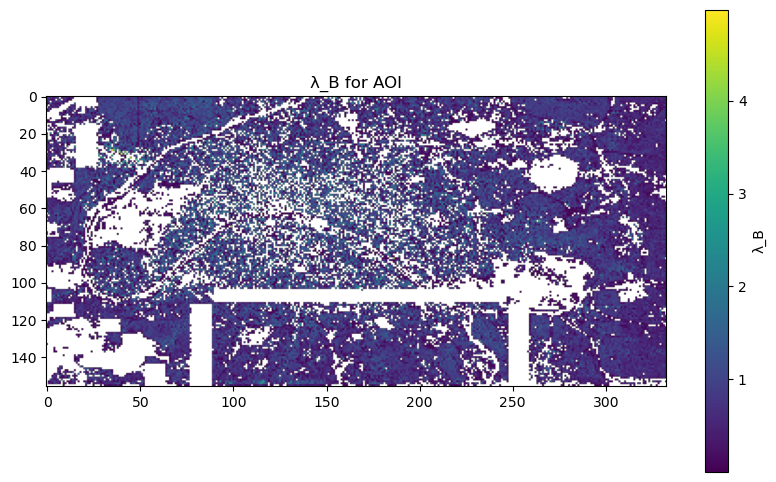

✅ λ_B raster successfully created.


In [245]:
# --- STEP 10: Save output ---
print(f"Saving raster to {output_raster_path}...")
with rasterio.open(output_raster_path, "w", **cropped_meta) as dest:
    dest.write(updated, 1)

plt.figure(figsize=(10, 6))
plt.imshow(np.ma.masked_equal(updated, invalid_height_value), cmap="viridis")
plt.title("λ_B for AOI")
plt.colorbar(label="λ_B")
plt.show()

print("✅ λ_B raster successfully created.")


In [178]:
print("Total grid cells:", len(grid_gdf))
print("Grid cells filled:", len(lambda_b_by_cell))
print("Buildings processed:", len(valid_buildings))
print("Joined entries:", len(joined))


Total grid cells: 48516
Grid cells filled: 32224
Buildings processed: 134895
Joined entries: 134895


Text(0.5, 1.0, 'Grid cells filled')

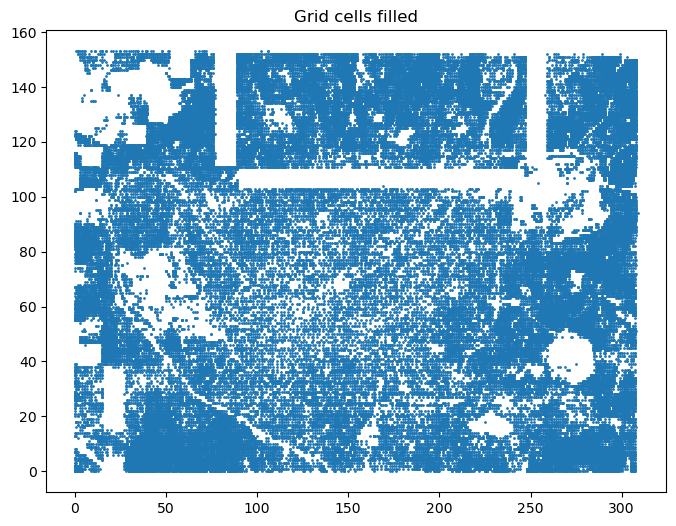

In [174]:
plt.figure(figsize=(8, 6))
plt.scatter(joined["col"], joined["row"], s=1)
plt.title("Grid cells filled")


In [171]:
print("Height range:", joined['height'].min(), joined['height'].max())
print("Perimeter range:", joined['perimeter'].min(), joined['perimeter'].max())
print("Roof area range:", joined['roof_area'].min(), joined['roof_area'].max())
print("Wall area range:", joined['wall_area'].min(), joined['wall_area'].max())
print("Lambda B range:", joined['lambda_b'].min(), joined['lambda_b'].max())
print("Cell area:", cell_area)


Height range: -9.199756622314453 132.57083504660088
Perimeter range: 7.221833746602116 690.6796800903105
Roof area range: 3.256194730080539 6610.0913852026
Wall area range: -736.2926929492824 29274.74216187666
Lambda B range: -673550209.7057998 40522709591.7931
Cell area: 8.1e-07


Merging and filling roof and ground rasters...
Resampling ground to match roof resolution...
Computing height raster...
Assigning heights to building footprints...
Cropping global raster to AOI...
Calculating λ_B values...
Saving λ_B raster to lambda_b_updated_Paris_lidar.tif...


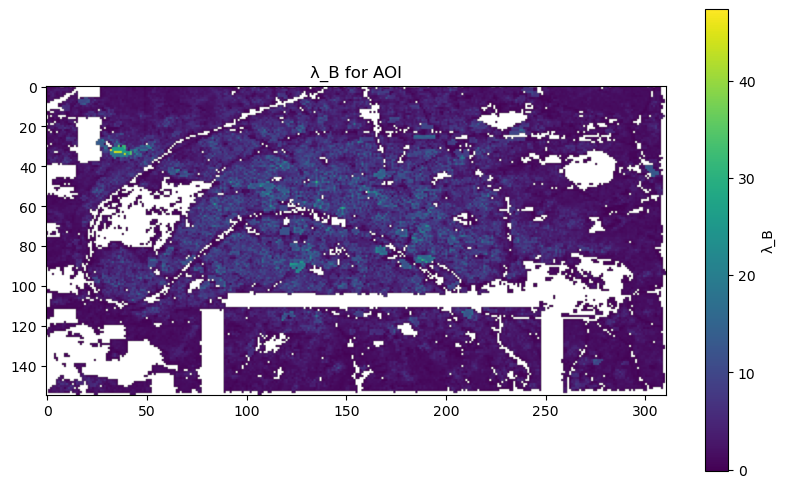

✅ Done.


In [155]:
import os
import numpy as np
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
from shapely.geometry import box
from rasterstats import zonal_stats
from scipy.ndimage import distance_transform_edt
from tqdm import tqdm

# --- PARAMETERS ---
roof_dir = "output_tiffs"
ground_dir = "output_tiffs"
building_fp = "/Users/gabeiras3j/01_year_2/01_Data/21_Microsoft_buildings/example_building_footprints_Paris.geojson"
global_raster_path = "/Users/gabeiras3j/Desktop/Jacobo/00_PhD/01_year_2/01_Data/02_WUDAPT/00_Global/lambda_b_v3_2d_correct_account.tiff"
output_raster_path = "lambda_b_updated_Paris_lidar.tif"
invalid_height_value = -9999

# --- UTIL: Fill missing data using nearest valid neighbor ---
def fill_nearest(data, nodata=-9999):
    mask = (data == nodata) | np.isnan(data)
    inds = distance_transform_edt(mask, return_distances=False, return_indices=True)
    return data[tuple(inds)]

# --- STEP 1: Merge tiles for roof and ground ---
def merge_tiles(tile_dir, keyword):
    files = [os.path.join(tile_dir, f) for f in os.listdir(tile_dir) if keyword in f and f.endswith(".tif")]
    srcs = [rasterio.open(f) for f in files]
    mosaic, out_trans = merge(srcs)
    meta = srcs[0].meta.copy()
    meta.update({"height": mosaic.shape[1], "width": mosaic.shape[2], "transform": out_trans, "dtype": "float32"})
    for src in srcs:
        src.close()
    return mosaic[0].astype(np.float32), meta

print("Merging and filling roof and ground rasters...")
roof_raw, meta = merge_tiles(roof_dir, "_roofs")
ground_raw, meta2 = merge_tiles(ground_dir, "_ground")

roof_filled = fill_nearest(np.where(roof_raw == invalid_height_value, np.nan, roof_raw), nodata=np.nan)
ground_filled = fill_nearest(np.where(ground_raw == invalid_height_value, np.nan, ground_raw), nodata=np.nan)

# --- STEP 2: Resample ground to match roof grid ---
print("Resampling ground to match roof resolution...")
resampled_ground = np.full_like(roof_filled, fill_value=invalid_height_value, dtype=np.float32)

reproject(
    source=ground_filled,
    destination=resampled_ground,
    src_transform=meta2["transform"],
    src_crs=meta2["crs"],
    dst_transform=meta["transform"],
    dst_crs=meta["crs"],
    resampling=Resampling.nearest,
    src_nodata=invalid_height_value,
    dst_nodata=invalid_height_value
)

# --- STEP 3: Compute height raster ---
print("Computing height raster...")
height_raster = roof_filled - resampled_ground
height_raster[roof_filled == 0] = np.nan

# --- STEP 4: Assign height to buildings ---
print("Assigning heights to building footprints...")
buildings = gpd.read_file(building_fp)
buildings = buildings.to_crs(meta["crs"])

zs = zonal_stats(buildings, height_raster, affine=meta["transform"], stats="mean", nodata=np.nan)
buildings["height"] = [z["mean"] if z["mean"] is not None else invalid_height_value for z in zs]
valid_buildings = buildings[buildings["height"] != invalid_height_value].copy()

# --- STEP 5: Crop global raster to AOI ---
print("Cropping global raster to AOI...")
with rasterio.open(global_raster_path) as src:
    global_crs = src.crs
    global_transform = src.transform
    global_meta = src.meta.copy()

    valid_buildings = valid_buildings.to_crs(global_crs)
    bbox = valid_buildings.total_bounds
    window_geom = box(*bbox)
    geo = gpd.GeoDataFrame({'geometry': [window_geom]}, crs=global_crs)
    out_image, out_transform = mask(src, geo.geometry, crop=True)
    cropped_meta = src.meta.copy()
    cropped_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "compress": "lzw",
        "tiled": True,
        "dtype": "float32"
    })
    global_array = out_image[0]

updated = np.full(global_array.shape, invalid_height_value, dtype=np.float32)

# --- STEP 6: Compute λ_B per grid cell ---
print("Calculating λ_B values...")

res_x = abs(out_transform[0])
res_y = abs(out_transform[4])
rows, cols = updated.shape

grid_polys = []
for row in range(rows):
    for col in range(cols):
        x, y = out_transform * (col + 0.5, row + 0.5)
        poly = box(x - res_x/2, y - res_y/2, x + res_x/2, y + res_y/2)
        grid_polys.append((row, col, poly))

grid_gdf = gpd.GeoDataFrame(
    [(r, c) for r, c, _ in grid_polys],
    geometry=[g for _, _, g in grid_polys],
    columns=["row", "col"],
    crs=global_crs
)

# Project buildings only (not the grid)
def get_utm_crs(geo_df):
    centroid = geo_df.unary_union.centroid
    lon, lat = centroid.x, centroid.y
    zone_number = int((lon + 180) / 6) + 1
    return f"EPSG:{32600 + zone_number}" if lat >= 0 else f"EPSG:{32700 + zone_number}"

projected_crs = get_utm_crs(valid_buildings)
valid_buildings_proj = valid_buildings.to_crs(projected_crs)
grid_gdf_proj = grid_gdf.to_crs(projected_crs)

joined = gpd.sjoin(valid_buildings_proj, grid_gdf_proj, how="inner", predicate="intersects")

joined["roof_area"] = joined.geometry.area
joined["perimeter"] = joined.geometry.length
joined["wall_area"] = joined["perimeter"] * joined["height"]

cell_area = grid_gdf_proj.geometry.iloc[0].area
joined["lambda_b"] = (joined["roof_area"] + joined["wall_area"]) / cell_area

lambda_b_by_cell = (
    joined.groupby(["row", "col"])
    .agg({"lambda_b": "sum"})
    .reset_index()
)

for _, row in lambda_b_by_cell.iterrows():
    r, c = int(row["row"]), int(row["col"])
    updated[r, c] = row["lambda_b"]

# --- STEP 7: Save output raster ---
print(f"Saving λ_B raster to {output_raster_path}...")
with rasterio.open(output_raster_path, "w", **cropped_meta) as dest:
    dest.write(updated, 1)

# --- Optional: Preview ---
plt.figure(figsize=(10, 6))
plt.imshow(np.ma.masked_equal(updated, invalid_height_value), cmap="viridis")
plt.title("λ_B for AOI")
plt.colorbar(label="λ_B")
plt.show()

print("✅ Done.")


In [157]:
print(lambda_b_by_cell["lambda_b"].describe())
print("Sample cell area (m²):", cell_area)


count    38537.000000
mean         3.818074
std          3.484323
min         -0.155577
25%          1.370833
50%          2.703011
75%          5.402833
max         47.353842
Name: lambda_b, dtype: float64
Sample cell area (m²): 6596.88372052096


In [158]:
grid_gdf_proj

,row,col,geometry
0,0,0,"POLYGON ((441825.62 5418944.333, 441826.665 54..."
1,0,1,"POLYGON ((441891.552 5418943.644, 441892.596 5..."
2,0,2,"POLYGON ((441957.484 5418942.957, 441958.526 5..."
3,0,3,"POLYGON ((442023.415 5418942.27, 442024.457 54..."
4,0,4,"POLYGON ((442089.347 5418941.584, 442090.388 5..."
...,...,...,...
48200,154,306,"POLYGON ((461895.817 5403363.074, 461896.498 5..."
48201,154,307,"POLYGON ((461961.931 5403362.624, 461962.611 5..."
48202,154,308,"POLYGON ((462028.046 5403362.175, 462028.725 5..."
48203,154,309,"POLYGON ((462094.161 5403361.727, 462094.838 5..."


In [60]:
import os
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.merge import merge
from rasterio.mask import mask
from shapely.geometry import box
from rasterstats import zonal_stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from rasterio.enums import Resampling

# --- Parameters ---
roof_dir = "output_tiffs"
ground_dir = "output_tiffs"
building_fp = "/Users/gabeiras3j/01_year_2/01_Data/21_Microsoft_buildings/example_building_footprints_Paris.geojson"
global_raster_path = "/Users/gabeiras3j/Desktop/Jacobo/00_PhD/01_year_2/01_Data/02_WUDAPT/00_Global/lambda_b_v3_2d_correct_account.tiff"
output_raster_path = "lambda_b_updated_Paris_lidar.tif"
invalid_height_value = -9999

# --- Step 1: Merge roof and ground rasters ---
def merge_tiles(tile_dir, keyword):
    files = [os.path.join(tile_dir, f) for f in os.listdir(tile_dir) if keyword in f and f.endswith('.tif')]
    srcs = [rasterio.open(f) for f in files]
    mosaic, out_trans = merge(srcs)
    meta = srcs[0].meta.copy()
    meta.update({"height": mosaic.shape[1], "width": mosaic.shape[2], "transform": out_trans})
    for src in srcs:
        src.close()
    return mosaic[0], meta


from pyproj import CRS
print(CRS.from_epsg(4326))


print("Merging roof and ground tiles...")
roof, meta = merge_tiles(roof_dir, "_roofs")
ground, meta2 = merge_tiles(ground_dir, "_ground")




EPSG:4326
Merging roof and ground tiles...
Resampling ground raster to match roof raster...


(array([[   34.03465415,    34.03465415,    34.03465415, ...,
         -2460.12154944, -4135.42787178, -5810.73419413],
        [   34.01147853,    34.01147853,    34.01147853, ...,
         -2460.13001671, -4135.43445743, -5810.73889816],
        [   33.98830291,    33.98830291,    33.98830291, ...,
         -2460.13848397, -4135.44104309, -5810.7436022 ],
        ...,
        [  161.2583113 ,   161.2583113 ,   161.2583113 , ...,
         -2474.86701329, -4146.89656589, -5818.92611849],
        [  161.2583113 ,   161.2583113 ,   161.2583113 , ...,
         -2474.86701329, -4146.89656589, -5818.92611849],
        [  161.2583113 ,   161.2583113 ,   161.2583113 , ...,
         -2474.86701329, -4146.89656589, -5818.92611849]],
       shape=(3201, 4201)),
 Affine(5.0, 0.0, 641000.0,
        0.0, -5.0, 6870005.0))

In [98]:
from scipy.ndimage import generic_filter

def fill_nan(data, size=3):
    return generic_filter(data, lambda x: np.nanmean(x), size=size, mode='nearest')

ground_filled = fill_nan(np.where(ground == -9999, np.nan, ground), size=5)


In [ ]:
from scipy.ndimage import generic_filter

def fill_nan(data, size=3):
    return generic_filter(data, lambda x: np.nanmean(x), size=size, mode='nearest')

ground_filled = fill_nan(np.where(ground == -9999, np.nan, ground), size=5)


In [118]:
roof_filled = fill_nan(np.where(roof == -9999, np.nan, roof), size=5)

In [100]:
# --- Step 1b: Resample ground raster to match roof raster's grid ---
from rasterio.warp import reproject, Resampling

print("Resampling ground raster to match roof raster...")

resampled_ground = np.empty_like(roof)

reproject(
    source=ground_filled,
    destination=resampled_ground,
    src_transform=meta2["transform"],
    src_crs=meta2["crs"],
    dst_transform=meta["transform"],
    dst_crs=meta["crs"],
    resampling=Resampling.bilinear  # or Resampling.nearest
)

Resampling ground raster to match roof raster...


(array([[ 33.80660463,  33.80660463,  33.80660463, ...,  51.47071993,
          51.61401109,  51.75730225],
        [ 33.78212616,  33.78212616,  33.78212616, ...,  51.47002828,
          51.61331226,  51.75659624],
        [ 33.75764769,  33.75764769,  33.75764769, ...,  51.46933663,
          51.61261343,  51.75589024],
        ...,
        [160.34720077, 160.34720077, 160.34720077, ...,  33.2369105 ,
          33.2842097 ,  33.33150889],
        [160.34720077, 160.34720077, 160.34720077, ...,  33.2369105 ,
          33.2842097 ,  33.33150889],
        [160.34720077, 160.34720077, 160.34720077, ...,  33.2369105 ,
          33.2842097 ,  33.33150889]], shape=(3201, 4201)),
 Affine(5.0, 0.0, 641000.0,
        0.0, -5.0, 6870005.0))

In [16]:
# # --- Step 2: Compute height raster ---
# print("Calculating height raster...")
# height_raster = roof - ground
# height_raster[(roof == 0) | (ground == 0)] = np.nan  # filter invalids

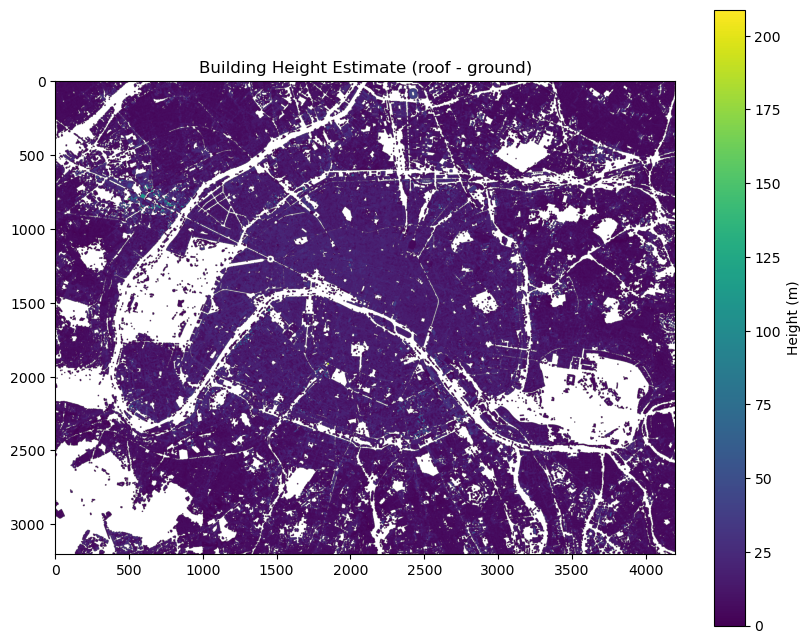

In [146]:
import matplotlib.pyplot as plt
import numpy as np

# Make sure there are no NaNs to break the color scale
diff = roof_filled - resampled_ground
diff = np.clip(diff, 0, 500)  # Ensure values are within the plotting range

plt.figure(figsize=(10, 8))
plt.imshow(diff, cmap="viridis")
plt.title("Building Height Estimate (roof - ground)")
plt.colorbar(label="Height (m)")
plt.show()


In [125]:
# --- Step 3: Assign roof and ground elevations to building footprints ---
print("Assigning roof and ground elevations to buildings...")
buildings = gpd.read_file(building_fp)
buildings = buildings.to_crs(meta["crs"])  # match raster CRS

# Get mean roof value per building
zs_roof = zonal_stats(buildings, diff, affine=meta["transform"], stats="mean", nodata=np.nan)
buildings["height"] = [z["mean"] if z["mean"] is not None else np.nan for z in zs_roof]
print(1)
# Filter buildings with valid height
valid_buildings = buildings[buildings["height"] != invalid_height_value].copy()


Assigning roof and ground elevations to buildings...
1


In [128]:
valid_buildings

,type,properties,id,geometry,height
0,Feature,"{ ""height"": 6.3150730133056641, ""confidence"": ...",0,"POLYGON ((641734.885 6866530.029, 641743.406 6...",5.560850
1,Feature,"{ ""height"": -1.0, ""confidence"": 0.969200015068...",1,"POLYGON ((641770.303 6869115.895, 641780.608 6...",5.400676
2,Feature,"{ ""height"": 3.430219173431396, ""confidence"": -...",2,"POLYGON ((641760.31 6863326.344, 641752.92 686...",4.813112
3,Feature,"{ ""height"": -1.0, ""confidence"": 0.997500002384...",3,"POLYGON ((641815.856 6868509.647, 641820.668 6...",NaN
4,Feature,"{ ""height"": 3.8227400779724121, ""confidence"": ...",4,"POLYGON ((641785.226 6863312.528, 641781.232 6...",5.072276
...,...,...,...,...,...
167853,Feature,"{ ""height"": 3.9778940677642822, ""confidence"": ...",167853,"POLYGON ((663592.328 6858689.952, 663600.198 6...",NaN
167854,Feature,"{ ""height"": -1.0, ""confidence"": -1.0 }",167854,"POLYGON ((663652.875 6868125.656, 663634.138 6...",NaN
167855,Feature,"{ ""height"": -1.0, ""confidence"": -1.0 }",167855,"POLYGON ((663580.054 6856266.106, 663580.778 6...",NaN
167856,Feature,"{ ""height"": 3.9184091091156001, ""confidence"": ...",167856,"POLYGON ((663615.274 6861810.725, 663621.365 6...",NaN


In [103]:
# # --- Step 3: Assign roof and ground elevations to building footprints ---
# print("Assigning roof and ground elevations to buildings...")
# buildings = gpd.read_file(building_fp)
# buildings = buildings.to_crs(meta["crs"])  # match raster CRS

# # Get mean roof value per building
# zs_roof = zonal_stats(buildings, roof, affine=meta["transform"], stats="mean", nodata=np.nan)
# buildings["roof"] = [z["mean"] if z["mean"] is not None else np.nan for z in zs_roof]
# print(1)
# # Get mean ground value per building
# buildings = buildings.to_crs(meta2["crs"])  # match raster CRS
# zs_ground = zonal_stats(buildings, resampled_ground, affine=meta["transform"], stats="mean", nodata=np.nan)
# buildings["ground"] = [z["mean"] if z["mean"] is not None else np.nan for z in zs_ground]
# print(2)
# # Compute building height only where both are valid
# buildings["height"] = buildings["roof"] - buildings["ground"]
# buildings["height"] = buildings["height"].fillna(invalid_height_value)
# print(3)
# # Filter buildings with valid height
# valid_buildings = buildings[buildings["height"] != invalid_height_value].copy()


Assigning roof and ground elevations to buildings...
1
2
3


In [33]:
# run this is need heights for testing
buildings['heightMS'] = [float(buildings['properties'][i][12:15]) for i in buildings.index]

In [42]:
# # Filter buildings with valid heights
# valid_buildings = buildings[buildings["heightMS"] != invalid_height_value].copy()

In [129]:
# --- Step 4: Load global raster and crop to AOI ---
print("Cropping global raster to area of interest...")
with rasterio.open(global_raster_path) as src:
    global_crs = src.crs
    global_transform = src.transform
    global_meta = src.meta.copy()

    # Reproject buildings to global raster CRS
    valid_buildings = valid_buildings.to_crs(global_crs)

    # Get bounding box of valid buildings and crop raster
    bbox = valid_buildings.total_bounds
    window_geom = box(*bbox)
    geo = gpd.GeoDataFrame({'geometry': [window_geom]}, crs=global_crs)
    out_image, out_transform = mask(src, geo.geometry, crop=True)
    cropped_meta = src.meta.copy()
    cropped_meta.update({
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform,
        "compress": "lzw",
        "tiled": True,
        "dtype": "float32"
    })
    global_array = out_image[0]


Cropping global raster to area of interest...


In [105]:
# 🔧 Add this immediately after:
updated = np.full(global_array.shape, invalid_height_value, dtype=np.float32)

In [106]:
updated.shape

(155, 311)

In [107]:
import warnings
warnings.filterwarnings('ignore')

In [148]:
from shapely.geometry import box
import math

print("Calculating λ_B values with full building geometries...")

# --- Step 5a: Build grid polygons (same CRS as cropped global raster) ---
rows, cols = updated.shape
res_x = abs(out_transform[0])
res_y = abs(out_transform[4])

grid_polys = []
for row in range(rows):
    for col in range(cols):
        x, y = out_transform * (col + 0.5, row + 0.5)
        poly = box(x - res_x / 2, y - res_y / 2, x + res_x / 2, y + res_y / 2)
        grid_polys.append((row, col, poly))

grid_gdf = gpd.GeoDataFrame(
    [(r, c) for r, c, _ in grid_polys],
    geometry=[g for _, _, g in grid_polys],
    columns=["row", "col"],
    crs=global_crs  # 🚫 DO NOT CHANGE — keep it aligned with the base raster
)

# --- Step 5b: Project buildings to UTM for accurate area/perimeter ---
def get_utm_crs(geo_df):
    centroid = geo_df.unary_union.centroid
    lon, lat = centroid.x, centroid.y
    zone_number = int((lon + 180) / 6) + 1
    return f"EPSG:{32600 + zone_number}" if lat >= 0 else f"EPSG:{32700 + zone_number}"

projected_crs = get_utm_crs(valid_buildings)
valid_buildings_proj = valid_buildings.to_crs(projected_crs)

# Also reproject grid_gdf temporarily (just for area calculation)
grid_gdf_proj = grid_gdf.to_crs(projected_crs)
cell_area = grid_gdf_proj.geometry.iloc[0].area  # consistent across grid

# --- Step 5c: Spatial join — no geometry intersection, just overlap ---
joined = gpd.sjoin(valid_buildings_proj, grid_gdf, how="inner", predicate="intersects")

# --- Step 5d: Compute λ_B per grid cell ---
joined["roof_area"] = joined.geometry.area
joined["perimeter"] = joined.geometry.length
joined["wall_area"] = joined["perimeter"] * joined["height"]
joined["lambda_b"] = (joined["roof_area"] + joined["wall_area"]) / cell_area

lambda_b_by_cell = (
    joined.groupby(["row", "col"])
    .agg({"lambda_b": "sum"})
    .reset_index()
)

# --- Step 5e: Fill the updated raster array ---
for _, row in lambda_b_by_cell.iterrows():
    r, c = int(row["row"]), int(row["col"])
    updated[r, c] = row["lambda_b"]

print("✅ Done calculating λ_B for your AOI without altering the base raster grid.")


Calculating λ_B values with full building geometries...
✅ Done calculating λ_B for your AOI without altering the base raster grid.


In [130]:
# from shapely.geometry import box
# import math

# print("Calculating λ_B values with full building geometries...")

# # --- Step 5a: Build grid polygons (same CRS as cropped global raster) ---
# rows, cols = updated.shape
# res_x = abs(out_transform[0])
# res_y = abs(out_transform[4])

# grid_polys = []
# for row in range(rows):
#     for col in range(cols):
#         x, y = out_transform * (col + 0.5, row + 0.5)
#         poly = box(x - res_x / 2, y - res_y / 2, x + res_x / 2, y + res_y / 2)
#         grid_polys.append((row, col, poly))

# grid_gdf = gpd.GeoDataFrame(
#     [(r, c) for r, c, _ in grid_polys],
#     geometry=[g for _, _, g in grid_polys],
#     columns=["row", "col"],
#     crs=global_crs  # 🚫 DO NOT change the grid CRS
# )

# # --- Step 5b: Project buildings to correct UTM for area/length ---
# def get_utm_crs(geo_df):
#     centroid = geo_df.unary_union.centroid
#     lon, lat = centroid.x, centroid.y
#     zone_number = int((lon + 180) / 6) + 1
#     return f"EPSG:{32600 + zone_number}" if lat >= 0 else f"EPSG:{32700 + zone_number}"

# projected_crs = get_utm_crs(valid_buildings)
# valid_buildings_proj = valid_buildings.to_crs(projected_crs)
# grid_proj = grid_gdf.to_crs(projected_crs)

# # --- Step 5c: Spatial join — just check overlap, no geometry clipping ---
# joined = gpd.sjoin(valid_buildings_proj, grid_proj, how="inner", predicate="intersects")

# # Compute full building footprint area & perimeter
# joined["roof_area"] = joined.geometry.area
# joined["perimeter"] = joined.geometry.length
# joined["wall_area"] = joined["perimeter"] * joined["height"]

# # Use area of the first grid cell (assumes all are same size in projected CRS)
# cell_area = grid_proj.geometry.iloc[0].area
# joined["lambda_b"] = (joined["roof_area"] + joined["wall_area"]) / cell_area

# # --- Step 5d: Group and fill the updated raster ---
# lambda_b_by_cell = (
#     joined.groupby(["row", "col"])
#     .agg({"lambda_b": "sum"})
#     .reset_index()
# )

# for _, row in lambda_b_by_cell.iterrows():
#     r, c = int(row["row"]), int(row["col"])
#     updated[r, c] = row["lambda_b"]

# print('Done')

Calculating λ_B values with full building geometries...
Done


In [142]:
cell_area = grid_proj.geometry.iloc[-1].area

In [149]:
cell_area

6596.88372052096

<Axes: >

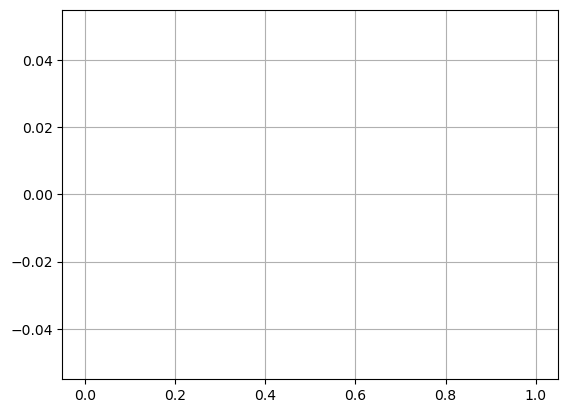

In [151]:
(joined["roof_area"] + joined["wall_area"]).hist(bins=70)

In [152]:
joined["roof_area"]

Series([], Name: roof_area, dtype: float64)

Saving updated raster to lambda_b_updated_Paris_lidar.tif...
✅ Done! You now have a λ_B raster that matches your global grid but only covers your city.


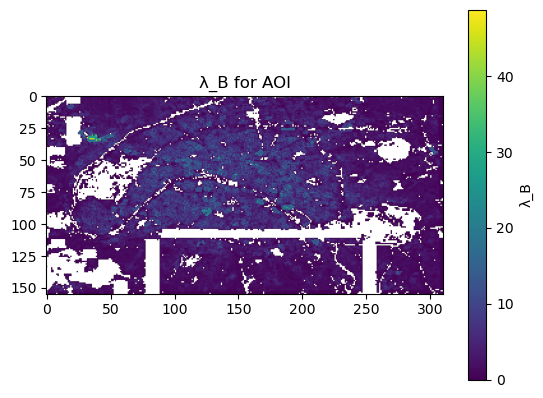

In [131]:
# --- Step 6: Save updated raster for city only ---
print(f"Saving updated raster to {output_raster_path}...")

with rasterio.open(output_raster_path, "w", **cropped_meta) as dest:
    dest.write(updated, 1)

print("✅ Done! You now have a λ_B raster that matches your global grid but only covers your city.")

# Optional: Show preview
plt.imshow(np.ma.masked_equal(updated, invalid_height_value), cmap='viridis')
plt.title("λ_B for AOI")
plt.colorbar(label="λ_B")
plt.show()


In [37]:
from shapely.geometry import Polygon

print("Vectorizing grid and calculating lambda_b...")

# Step 5a: Generate grid as GeoDataFrame
grid_polys = []
rows, cols = updated.shape
for row in range(rows):
    for col in range(cols):
        x, y = out_transform * (col + 0.5, row + 0.5)
        poly = box(x - res_x / 2, y - res_y / 2, x + res_x / 2, y + res_y / 2)
        grid_polys.append((row, col, poly))


Vectorizing grid and calculating lambda_b...


NameError: name 'updated' is not defined

In [36]:
# Keep grid in its original CRS from global raster
grid_gdf = gpd.GeoDataFrame(
    [(r, c) for r, c, _ in grid_polys],
    geometry=[g for _, _, g in grid_polys],
    columns=["row", "col"],
    crs=global_crs  # do NOT change this
)

# Auto-detect projected CRS for accurate area/length calculations
def get_utm_crs(geo_df):
    centroid = geo_df.unary_union.centroid
    lon, lat = centroid.x, centroid.y
    zone_number = int((lon + 180) / 6) + 1
    epsg_code = 32600 + zone_number if lat >= 0 else 32700 + zone_number
    return f"EPSG:{epsg_code}"

# Reproject buildings to projected CRS for area calculations
projected_crs = get_utm_crs(valid_buildings)
valid_buildings_proj = valid_buildings.to_crs(projected_crs)
grid_proj = grid_gdf.to_crs(projected_crs)

# Intersect in projected space (clipped shapes per grid cell)
intersection = gpd.overlay(valid_buildings_proj, grid_proj, how="intersection")

# Compute cell area from projected grid geometry
cell_area = grid_proj.geometry.iloc[0].area
print(f"Cell area (m²): {cell_area}")

# Compute roof + wall areas (in meters²)
intersection["roof_area"] = intersection.geometry.area
intersection["perimeter"] = intersection.geometry.length
intersection["wall_area"] = intersection["perimeter"] * intersection["heightMS"]
intersection["lambda_b"] = (intersection["wall_area"] + intersection["roof_area"]) / cell_area

# Group by original row/col
lambda_b_by_cell = (
    intersection.groupby(["row", "col"])
    .agg({"lambda_b": "sum"})
    .reset_index()
)

# 🔁 Write values back to your unchanged grid array
for _, row in lambda_b_by_cell.iterrows():
    r, c = int(row["row"]), int(row["col"])
    updated[r, c] = row["lambda_b"]

print('Done')

NameError: name 'grid_polys' is not defined

Saving updated raster to lambda_b_updated_Paris.tif...
✅ Done! You now have a λ_B raster that matches your global grid but only covers your city.


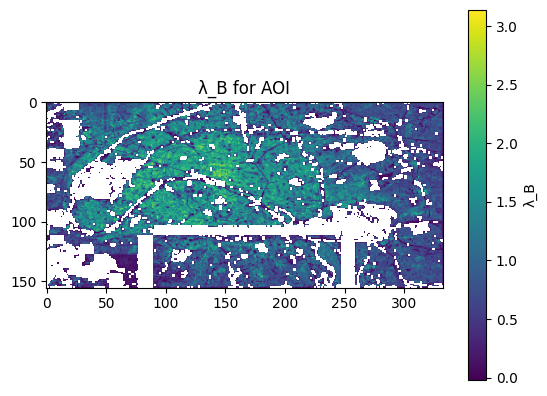

In [83]:
# --- Step 6: Save updated raster for city only ---
print(f"Saving updated raster to {output_raster_path}...")

with rasterio.open(output_raster_path, "w", **cropped_meta) as dest:
    dest.write(updated, 1)

print("✅ Done! You now have a λ_B raster that matches your global grid but only covers your city.")

# Optional: Show preview
plt.imshow(np.ma.masked_equal(updated, invalid_height_value), cmap='viridis')
plt.title("λ_B for AOI")
plt.colorbar(label="λ_B")
plt.show()


In [89]:
lambda_b_by_cell.to_pickle('lambda_b_by_cell_Paris_lidar.pkl')